In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import seaborn as sns
import matplotlib.pyplot as plt

In [77]:
df = pd.read_csv('/content/drive/MyDrive/CustomerChurn_dataset.csv')

In [78]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [79]:
df = df.drop('customerID', axis = 1)

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [81]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(method='ffill', inplace=True)

<ipython-input-86-ff8098f04e29>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr(method= 'spearman')


<Axes: >

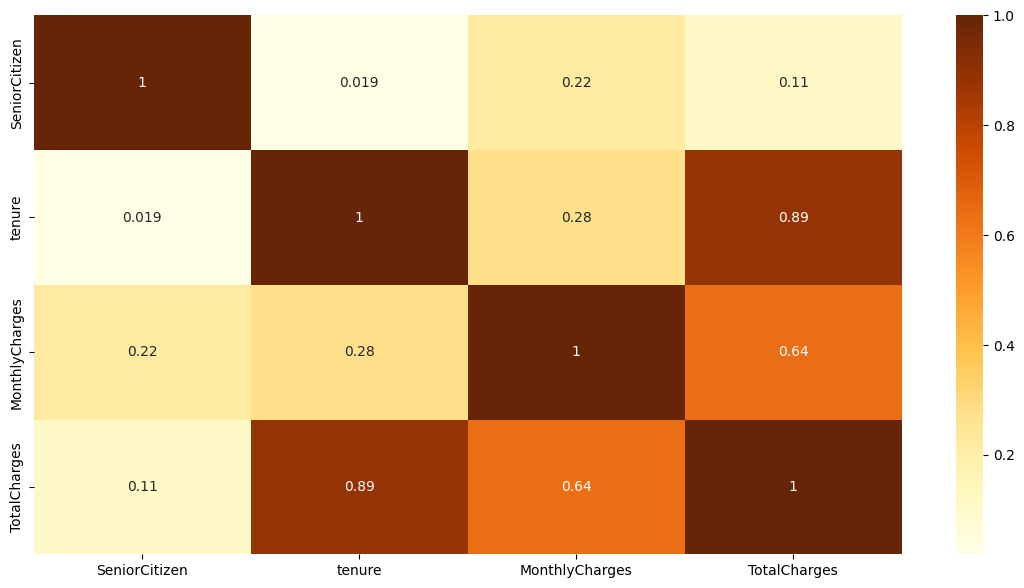

In [86]:
corr_matrix = df.corr(method= 'spearman')
plt.figure(figsize = (14, 7))
sns.heatmap(corr_matrix, annot = True, cmap='YlOrBr')

In [83]:
categorical_values = df.drop(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges' ], axis = 1)

In [84]:
label_encoder = preprocessing.LabelEncoder()
categorical_df = categorical_values.apply(label_encoder.fit_transform)
categorical_df.head(14)

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0
1,1,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0
2,1,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1
3,1,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0
4,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1
5,0,0,0,1,2,1,0,0,2,0,2,2,0,1,2,1
6,1,0,1,1,2,1,0,2,0,0,2,0,0,1,1,0
7,0,0,0,0,1,0,2,0,0,0,0,0,0,0,3,0
8,0,1,0,1,2,1,0,0,2,2,2,2,0,1,2,1
9,1,0,1,1,0,0,2,2,0,0,0,0,1,0,0,0


In [11]:
label_encoder = preprocessing.LabelEncoder()
categorical_df = categorical_values.apply(label_encoder.fit_transform)
new_numeric = df[['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']]
df = pd.merge(new_numeric, categorical_df, left_index=True, right_index=True)
df

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,0,1,29.85,29.85,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0
1,0,34,56.95,1889.50,1,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0
2,0,2,53.85,108.15,1,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1
3,0,45,42.30,1840.75,1,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0
4,0,2,70.70,151.65,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84.80,1990.50,1,1,1,1,2,0,2,0,2,2,2,2,1,1,3,0
7039,0,72,103.20,7362.90,0,1,1,1,2,1,0,2,2,0,2,2,1,1,1,0
7040,0,11,29.60,346.45,0,1,1,0,1,0,2,0,0,0,0,0,0,1,2,0
7041,1,4,74.40,306.60,1,1,0,1,2,1,0,0,0,0,0,0,0,1,3,1


In [12]:
missing_values = df.isnull().sum()
missing_values

SeniorCitizen       0
tenure              0
MonthlyCharges      0
TotalCharges        0
gender              0
Partner             0
Dependents          0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
Churn               0
dtype: int64

In [13]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rforrest_classifier = RandomForestClassifier(n_estimators=112, max_depth=12, criterion='entropy')


In [14]:
rforrest_classifier.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', max_depth=12, n_estimators=112)

In [15]:
feature_importance = rforrest_classifier.feature_importances_

In [16]:
for name, score in zip(X.columns, feature_importance):
  print(name,'=', score)

SeniorCitizen = 0.017378660950239856
tenure = 0.158283349112643
MonthlyCharges = 0.15780288016844973
TotalCharges = 0.16841328399021066
gender = 0.022337382492326117
Partner = 0.02048963465264422
Dependents = 0.019348413165588937
PhoneService = 0.006861578517261717
MultipleLines = 0.022506911324441735
InternetService = 0.03523171044256906
OnlineSecurity = 0.05931002965458
OnlineBackup = 0.025646011484440234
DeviceProtection = 0.01939018503383044
TechSupport = 0.04370414182117209
StreamingTV = 0.01648517755042727
StreamingMovies = 0.01828440258302599
Contract = 0.1147198905342135
PaperlessBilling = 0.025545021067522225
PaymentMethod = 0.04826133545441319


In [17]:
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df.iloc[0:20]

,Feature,Importance
3,TotalCharges,0.168413
1,tenure,0.158283
2,MonthlyCharges,0.157803
16,Contract,0.114720
10,OnlineSecurity,0.059310
18,PaymentMethod,0.048261
13,TechSupport,0.043704
9,InternetService,0.035232
11,OnlineBackup,0.025646
17,PaperlessBilling,0.025545


In [18]:
X_data = df.drop('Churn', axis=1)
Y_data = df['Churn']
mi_scores = mutual_info_classif(X_data, Y_data)
mi_scores = pd.Series(mi_scores, index=X_data.columns)
mi_scores.sort_values(ascending=False, inplace=True)
print(mi_scores)

Contract            0.099241
tenure              0.070376
OnlineSecurity      0.068294
TechSupport         0.064963
InternetService     0.051834
OnlineBackup        0.051360
MonthlyCharges      0.049782
TotalCharges        0.042904
DeviceProtection    0.040127
PaymentMethod       0.038711
StreamingMovies     0.033344
PaperlessBilling    0.032526
StreamingTV         0.027568
Dependents          0.018239
SeniorCitizen       0.010061
Partner             0.007974
MultipleLines       0.007091
PhoneService        0.005812
gender              0.000000
dtype: float64


In [19]:
selected_features = ['TotalCharges',	'MonthlyCharges',	'tenure', 'Contract',	'OnlineSecurity',	'PaymentMethod' ,'TechSupport'	, 'InternetService'	,	'PaperlessBilling', 'DeviceProtection', 'Churn'  ]
df_selected = df[selected_features]


In [20]:
#training and test split
X = df_selected.drop('Churn', axis=1)
y = df_selected['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
#Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
# MLP Model using Functional API
input_layer = Input(shape=(X_train_scaled.shape[1],))
hidden_layer_1 = Dense(64, activation='relu')(input_layer)
hidden_layer_2 = Dense(32, activation='relu')(hidden_layer_1)
output_layer = Dense(1, activation='sigmoid')(hidden_layer_2)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

y_pred = model.predict(X_test_scaled)
y_pred_classes = (y_pred > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_pred_classes)
auc_score = roc_auc_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"AUC Score: {auc_score:.2f}")
print(classification_report(y_test, y_pred_classes))


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_3 (Dense)             (None, 64)                704       
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
141/141 [==============================] - 2s 3ms/step - loss: 0.4631 - accuracy: 0.7739 - val_loss: 0.4138 - val_accuracy: 0.8048
Epoch 2/100
14

In [23]:
from sklearn.metrics import auc, roc_auc_score, roc_auc_score, roc_curve
from keras.callbacks import Callback

In [24]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

In [25]:
auc_keras = auc(fpr_keras, tpr_keras)

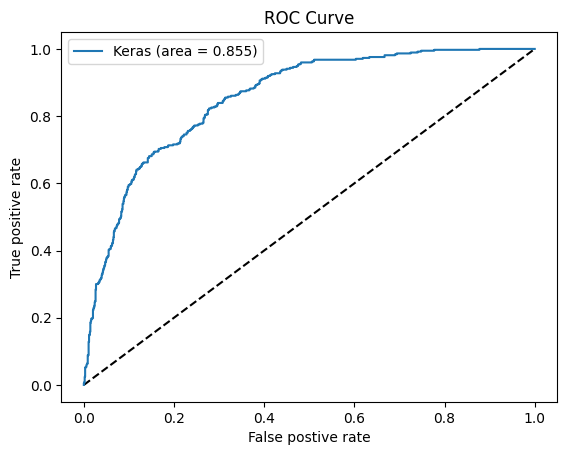

In [26]:
plt.figure(1)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr_keras, tpr_keras, label = 'Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False postive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [27]:
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['sgd', 'adam'],
    'max_iter': [150, 200, 300],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128]
}

In [28]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

In [32]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.4 MB/s eta 0:00:00


In [33]:
import keras_tuner
from tensorflow import keras

In [38]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(X_train.shape[1],)))

    for i in range(hp.Int('num_hidden_layers', min_value=1, max_value=4)):
        model.add(keras.layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=96, step=32), activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh'])))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    learning_rate = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [42]:
tuner = keras_tuner.Hyperband(build_model, objective='val_accuracy', max_epochs=100, factor=3, directory='tuning_dir', project_name='samples')
tuner.search(X_train_scaled, y_train, epochs=10, validation_split=0.2)

Trial 254 Complete [00h 00m 56s]
val_accuracy: 0.8127772808074951

Best val_accuracy So Far: 0.8243123292922974
Total elapsed time: 00h 39m 59s


In [44]:
best_model = tuner.get_best_models(num_models=2)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 96)                1056      
                                                                 
 dense_1 (Dense)             (None, 96)                9312      
                                                                 
 dense_2 (Dense)             (None, 32)                3104      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13505 (52.75 KB)
Trainable params: 13505 (52.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
y_pred = best_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

45/45 [==============================] - 0s 2ms/step


In [48]:
best_model.save('optimal_model.h5')

In [49]:
import pickle
with open('Scaled.pkl', 'wb') as file:
  pickle.dump(scaler, file)